# MVC project: exploration
- This notebook explores data generated by matlab

## Todos
- participant count
- homogeneity datasets

# 1. Import data

In [1]:
import mvc  # local functions (see mvc/ folder)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
% matplotlib inline

In [2]:
data_path = '/media/romain/E/Projet_MVC/data/Final_output'
mat = mvc.fileio.Fileio(data_path)

project 'Sylvain_2015' loaded (10 participants)
project 'Landry_2013' loaded (21 participants)
project 'Landry_2012' loaded (18 participants)
project 'Landry_2015_2' loaded (11 participants)
project 'Yoann_2015' loaded (22 participants)
project 'Landry_2015_1' loaded (14 participants)
project 'Patrick_2013' loaded (16 participants)
	total participants: 112


In [16]:
# load data
data_path = '/media/romain/E/Projet_MVC/data/Final_output'
mat = {}
count = 0
for ifile in os.listdir(data_path):
    if ifile.endswith('.mat'):
        name = ifile.replace('MVE_Data_', '').replace('.mat', '')
        mat[name] = {}
        mat[name]['path'] = os.path.join(data_path, ifile)
        mat[name]['data'] = sio.loadmat(mat[name]['path'])
        count += mat[name]['data']['MVE'].shape[0]
        print("project '{}' loaded ({} participants)".format(name, mat[name]['data']['MVE'].shape[0]))
print('\ttotal participants: {}'.format(count))

project 'Sylvain_2015' loaded (10 participants)
project 'Landry_2013' loaded (21 participants)
project 'Landry_2012' loaded (18 participants)
project 'Landry_2015_2' loaded (11 participants)
project 'Yoann_2015' loaded (22 participants)
project 'Landry_2015_1' loaded (14 participants)
project 'Patrick_2013' loaded (16 participants)
	total participants: 112


## Dimensions description
- `mat['data']` contains the `MVE` variable with three dimensions: $\text{participant}(n) \times \text{muscle}(12) \times \text{test}(15)$

In [6]:
# 3d matrix to lists
participants = []
datasets = []
muscles = []
tests = []
relative_mvc = []

for idataset in list(mat.keys()):
    for iparticipant in range(mat[idataset]['data']['MVE'].shape[0]):
        for imuscle in range(mat[idataset]['data']['MVE'].shape[1]):
            max_mvc = np.nanmax(mat[idataset]['data']['MVE'][iparticipant, imuscle, :])
            for itest in range(mat[idataset]['data']['MVE'].shape[2]):
                participants.append(iparticipant+1)
                datasets.append(idataset)
                muscles.append(imuscle+1)
                tests.append(itest+1)
                # normalize mvc (relative to max)
                relative_mvc.append(mat[idataset]['data']['MVE'][iparticipant, imuscle, itest]*100/max_mvc)

/home/romain/anaconda3/envs/mvc/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# lists to single dataframe
df = pd.DataFrame({
    'participant': participants,
    'dataset': datasets,
    'muscle': muscles,
    'test': tests,
    'relative_mvc': relative_mvc,
}).dropna()

df.head(1)

,dataset,muscle,participant,relative_mvc,test
0,Sylvain_2015,1,1,100.0,1


## Data description

In [11]:
# pivot table: muscle count
table_muscle = df.pivot_table(values='test',index='dataset', columns='muscle', aggfunc=lambda x: len(x)/x.nunique())
table_muscle.loc['total'] = table_muscle.sum(axis=0)
table_muscle['n'] = table_muscle.notnull().sum(axis=1)
table_muscle

muscle,1,2,3,4,5,6,7,8,9,10,11,12,n
dataset,,,,,,,,,,,,,
Landry_2012,18.0,18.0,18.0,18.0,18.0,18.0,18.0,NaN,18.0,NaN,NaN,NaN,8
Landry_2013,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,NaN,NaN,NaN,9
Landry_2015_1,14.0,NaN,14.0,14.0,14.0,14.0,NaN,14.0,NaN,14.0,14.0,14.0,9
Landry_2015_2,11.0,NaN,11.0,11.0,11.0,11.0,NaN,11.0,NaN,NaN,NaN,NaN,6
Patrick_2013,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,12
Sylvain_2015,10.0,10.0,10.0,NaN,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,11
Yoann_2015,22.0,22.0,22.0,NaN,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,11
total,112.0,87.0,112.0,80.0,112.0,112.0,87.0,94.0,87.0,62.0,62.0,62.0,12


In [12]:
# pivot table: test count
table_test = df.pivot_table(values='muscle', index='dataset', columns='test', aggfunc=lambda x: len(x)/x.nunique())
table_test.loc['total'] = table_test.sum(axis=0)
table_test['n'] = table_test.notnull().sum(axis=1)
table_test

test,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,n
dataset,,,,,,,,,,,,,,,,
Landry_2012,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
Landry_2013,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,9
Landry_2015_1,14.0,NaN,14.0,14.0,14.0,14.0,NaN,NaN,14.0,14.0,14.0,NaN,NaN,NaN,14.0,9
Landry_2015_2,11.0,NaN,11.0,11.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6
Patrick_2013,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,15
Sylvain_2015,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,15
Yoann_2015,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,15
total,112.0,87.0,112.0,112.0,112.0,112.0,87.0,87.0,62.0,62.0,62.0,48.0,48.0,48.0,94.0,15


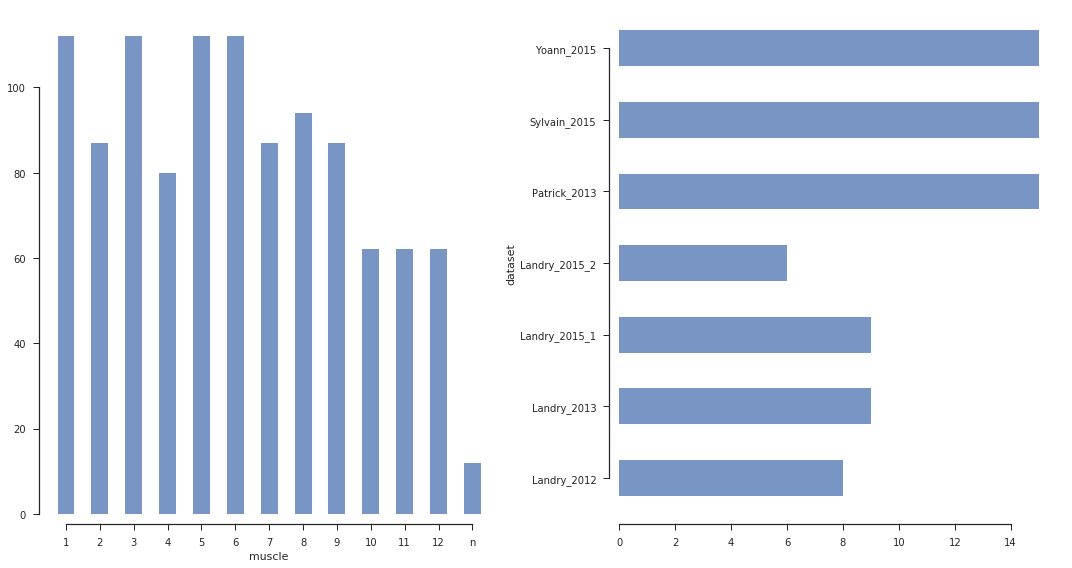

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
table_muscle.loc['total'].plot.bar(ax=ax1, alpha=.75)
table_test.drop('total', axis=0)['n'].plot.barh(ax=ax2, alpha=.75)
sns.despine(offset=10, trim=True)
fig.tight_layout()

- Muscles `10`, `11` and `12`  (_intras_) have only $62$ mvc
- Muscles `1`, `3`, `5` and `6` have $112$ mvc
---
- The following datasets have performed the $15$ tests: `Yoann_2015`, `Sylvain_2015` and `Patrick_2013`
- `Landry_2015_2` have only $6$ tests and `Landry_2012` $8$

# 2. Datasets Homogeneity


# 3. Overall visualization

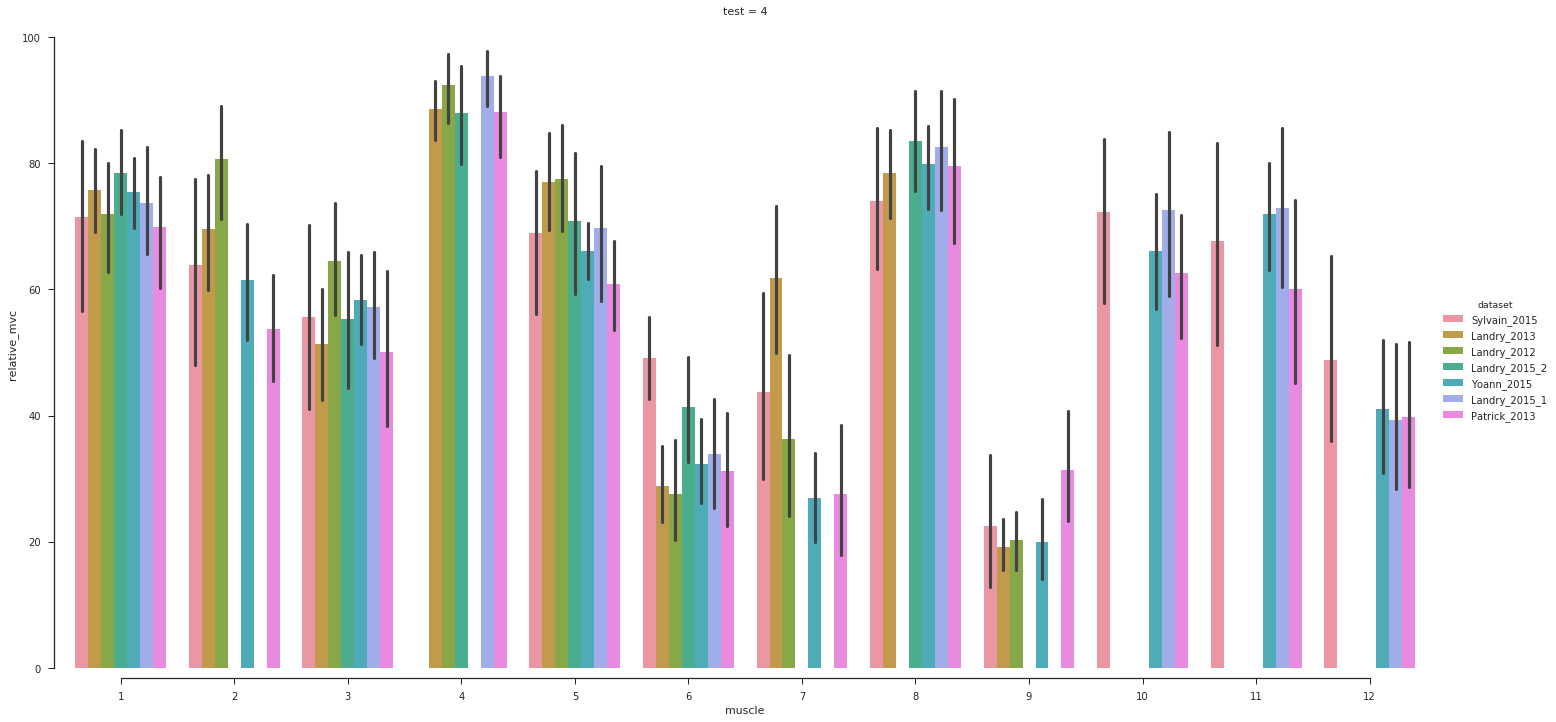

In [6]:
plt.figure(figsize=(45, 10))
sns.factorplot(x='muscle', y='relative_mvc',
               hue='dataset', row='test',
               data=df[df.test == 4], kind='bar',
               size=10, aspect=2)
sns.despine(offset=10, trim=True)
